In [39]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.keras import metrics
from sklearn import datasets
import pandas as pd
import numpy as np
#import pandas_profiling as pp
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

## Load and Clean Data

In [3]:
# Read in CSV
df = pd.read_csv("final_project.csv")
print(len(df))

160000


In [4]:
df['x37']

0          $1313.96
1          $1962.78
2           $430.47
3         $-2366.29
4          $-620.66
            ...    
159995     $-891.96
159996     $1588.65
159997      $687.46
159998      $439.21
159999    $-1229.34
Name: x37, Length: 160000, dtype: object

In [5]:
# Rename obvious columns
df.rename(columns={'x24': 'continent', 'x29': 'month', 'x30': 'day'}, inplace = True)
#list(df.columns) 

In [6]:
# initialize temp for x37 column
temp_x37 = []

# Remove $ ) , characters and replace '(' with '-' 
for i in range (0,len(df)) :
    try :
        n = df['x37'][i]
        nstr = re.sub(r'[$|,|)]',r'', n)
        nstr = re.sub(r'[(]',r'-',nstr)
        #nstr= float(nstr)
        temp_x37.append(nstr)
    except :
        nstr = ''
        temp_x37.append(nstr)

In [7]:
# Verify len of both x37 matches
print(len(df['x37']))
print(len(temp_x37))

# Replace 'x37' with new values and convert to numeric
df['x37'] = temp_x37
df["x37"] = pd.to_numeric(df["x37"])
df['x37']

160000
160000


0         1313.96
1         1962.78
2          430.47
3        -2366.29
4         -620.66
           ...   
159995    -891.96
159996    1588.65
159997     687.46
159998     439.21
159999   -1229.34
Name: x37, Length: 160000, dtype: float64

In [8]:
# Correct misspellings and standardize values in labeled columns
df['continent'].replace('euorpe', 'europe',inplace=True)
df['month'].replace('Dev', '12',inplace=True)
df['month'].replace('Aug', '8',inplace=True)
df['month'].replace('Jun', '6',inplace=True)
df['month'].replace('Apr', '4',inplace=True)
df['month'].replace('Nov', '11',inplace=True)
df['month'].replace('sept.', '9',inplace=True)
df['month'].replace('Oct', '10',inplace=True)
df['month'].replace('Mar', '3',inplace=True)
df['month'].replace('January', '1',inplace=True)
df['month'].replace('Feb', '2',inplace=True)
df['month'].replace('May', '5',inplace=True)
df['month'].replace('July', '7',inplace=True)
df['month'].replace('December', '12',inplace=True)
df['month'].replace('August', '8',inplace=True)
df['month'].replace('June', '6',inplace=True)
df['month'].replace('April', '4',inplace=True)
df['month'].replace('November', '11',inplace=True)
df['month'].replace('September', '9',inplace=True)
df['month'].replace('October', '10',inplace=True)
df['month'].replace('March', '3',inplace=True)
df['day'].replace('thurday', 'thursday',inplace=True)
df['day'].replace('thursday', '4', inplace=True)
df['day'].replace('friday', '5', inplace=True)
df['day'].replace('monday', '1', inplace=True)
df['day'].replace('tuesday', '2', inplace=True)
df['day'].replace('wednesday', '3', inplace=True)
df['continent'].replace('europe', '3',inplace=True)
df['continent'].replace('asia', '2',inplace=True)
df['continent'].replace('america', '1',inplace=True)

# Fill NA with 'other' in labeled columns
df['continent'] = df['continent'].fillna('other')
df['month'] = df['month'].fillna('other')
df['day'] = df['day'].fillna('other')
df['month'].replace('other','0', inplace=True)
df['day'].replace('other', '0', inplace=True)
df['continent'].replace('other', '4',inplace=True)



# check unique values in labeled columns
print (df['continent'].unique())
print (df['month'].unique())
print (df['day'].unique())

['3' '2' '1' '4']
['7' '8' '6' '5' '9' '4' '11' '10' '0' '3' '2' '12' '1']
['2' '3' '4' '1' '5' '0']


In [9]:
#Remove % sign from x32
df['x32']=(df['x32'].str.rstrip('%').astype('float'))

In [10]:
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,y
0,-0.166563,-3.961588,4.621113,2.481908,-1.800135,0.804684,6.718751,-14.789997,-1.040673,-4.204950,...,-1.497117,5.414063,-2.325655,1.674827,-0.264332,60.781427,-7.689696,0.151589,-8.040166,0
1,-0.149894,-0.585676,27.839856,4.152333,6.426802,-2.426943,40.477058,-6.725709,0.896421,0.330165,...,36.292790,4.490915,0.762561,6.526662,1.007927,15.805696,-4.896678,-0.320283,16.719974,0
2,-0.321707,-1.429819,12.251561,6.586874,-5.304647,-11.311090,17.812850,11.060572,5.325880,-2.632984,...,-0.368491,9.088864,-0.689886,-2.731118,0.754200,30.856417,-7.428573,-2.090804,-7.869421,0
3,-0.245594,5.076677,-24.149632,3.637307,6.505811,2.290224,-35.111751,-18.913592,-0.337041,-5.568076,...,15.691546,-7.467775,2.940789,-6.424112,0.419776,-72.424569,5.361375,1.806070,-7.670847,0
4,-0.273366,0.306326,-11.352593,1.676758,2.928441,-0.616824,-16.505817,27.532281,1.199715,-4.309105,...,-13.911297,-5.229937,1.783928,3.957801,-0.096988,-14.085435,-0.208351,-0.894942,15.724742,1


In [16]:
#Fill NA with mean
dfmean=df.fillna(df.mean())

#Drop any row with NA
dfdrop=df.dropna()

# KNN-dropNA-K=5

In [22]:
#Create x and y

x=dfdrop.iloc[:,0:50].values
y=dfdrop.iloc[:,-1].values

In [18]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [19]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [20]:
#Training and Predictions
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [21]:
y_pred=classifier.predict(x_test)

In [23]:
#Evaluating Results
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[16670  2397]
 [ 3416  9213]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85     19067
           1       0.79      0.73      0.76     12629

    accuracy                           0.82     31696
   macro avg       0.81      0.80      0.81     31696
weighted avg       0.82      0.82      0.82     31696



# KNN-MeanNA-K=5
# Spoiler: Got same results as dropNA, scroll down

In [24]:
#Create x and y

x1=dfmean.iloc[:,0:50].values
y1=dfmean.iloc[:,-1].values

In [25]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.20)

In [26]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [27]:
#Training and Predictions
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [28]:
y_pred=classifier.predict(x_test)

In [31]:
#Evaluating Results

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[16793  2364]
 [ 3485  9358]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85     19157
           1       0.80      0.73      0.76     12843

    accuracy                           0.82     32000
   macro avg       0.81      0.80      0.81     32000
weighted avg       0.82      0.82      0.82     32000



# KNN Loop K=1-10 to find best K value

In [32]:
#Create x and y

x=dfdrop.iloc[:,0:50].values
y=dfdrop.iloc[:,-1].values

In [33]:
#TrainTestSplit

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [34]:
#feature scaling

scaler=StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test=scaler.transform(x_test)

In [35]:
error = []

# Calculating error for K values between 1 and 10
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

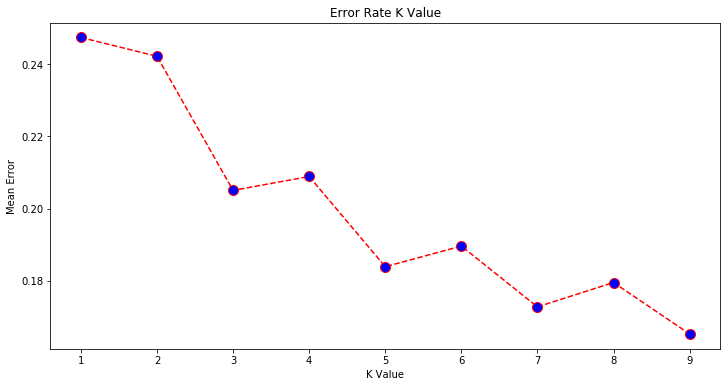

In [40]:
#Visualize it 
# Source: https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/

plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Explore Other combinations of data. Ignore for now

In [ ]:
#Create new column for sum of all rows except: continent, month, day, x32, x37, and y.
df['Total']=df[['x0','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x25','x26','x27','x28','x31','x33','x34','x35','x36','x38','x39','x40','x41','x42','x43','x44','x45','x46','x47','x48','x49']].sum(axis=1)

In [ ]:
#Create new dataframe with categorical variables, percent, Money Amount, y, and new total column
newdf=df[['continent', 'month', 'day', 'x32', 'x37', 'y', 'Total']]

In [ ]:
newdf.info()

In [ ]:
#new dataset that adds 2 columns: New total column that also adds x37, and a column that divides the Total column by x37
calcdf=newdf.assign(FullTotal=lambda x: newdf['x37']+newdf['Total'],
             TotalDiv37=lambda x: newdf['Total']/newdf['x37'])

In [ ]:
#new dataset that adds 2 more columns: Full total x the percentage number, and total (without x37) x the percentage number
calcdf=calcdf.assign(FullTotalXPerc=lambda x: calcdf['FullTotal']*calcdf['x32'],
                     TotalXPerc=lambda x: calcdf['Total']*calcdf['x32'])

calcdf.head(3)

In [ ]:
g=sns.catplot(x='continent', y='month', hue='y', data=calcdf_noNA, jitter='0.40')
